In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, MultiTaskElasticNetCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC

In [2]:
import logging
logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

In [3]:
data_path='../final/'
save_path='../final/'

# Import data

In [4]:
(Y_train, T_train, X_train, W_train)=pickle.load(open(data_path+'YTXW_train.pkl','rb'))
(Y_test, T_test, X_test, W_test)=pickle.load(open(data_path+'YTXW_test.pkl','rb'))
(Y_val, T_val, X_val, W_val)=pickle.load(open(data_path+'YTXW_val.pkl','rb'))

In [5]:
le_dx=pickle.load(open(data_path+'le_dx.pkl','rb'))
le_patid=pickle.load(open(data_path+'le_patid.pkl','rb'))
selected_patient_feature=['age_onset','obs_win','female']+['race__'+c for c in ['A','B','H','U','W']]
rx2id = pickle.load(open(data_path+'drug_dict.pkl', 'rb'))

In [6]:
len(X_train)

6771

In [7]:
T_train.head()

,patid,antiasthma,log_count
9722,9722,1,1.945910
1232,1232,5,1.386294
2220,2220,1,3.583519
1806,1806,4,0.693147
9768,9768,2,1.386294


In [8]:
len(W_train['phecode3'].unique())

242

In [9]:
len(X_train)

6771

# Process Y,T,W,X

Several steps:
- Standardize age
- Combine demographics with dx information 
- Set treatment and control group
- Output a dataframe

In [10]:
from sklearn import preprocessing

def prepare(y, t, w, x, rx2id, target):
    patid_temp = list(w['patid'].unique())
    temp_le = preprocessing.LabelEncoder()
    temp_le.fit(list(patid_temp))
    w['row_idx'] = temp_le.transform(w['patid'])
    
    w_sparse = csr_matrix((w['log_count'], (w['row_idx'], w['phecode3'])))
    w = w_sparse.toarray()
    
    x_temp = np.concatenate((w, x.values), axis=1)
    
    treatment_train = [0] * len(t)
    temp_index = t.index
    idx = 0

    def get_classes(value):
        return [k for k, v in rx2id.items() if v == value]

    for i in temp_index:
        classes = t.loc[i, 'antiasthma']
        if (classes != target):
            treatment_train[idx] = 'control'
        else:
            treatment_train[idx] = 'Leukotriene receptor antagonist'
        idx += 1
        
    treatment = pd.DataFrame(treatment_train)
    treatment.index = temp_index
    treatment.columns = ['treatment']
    
    y = pd.DataFrame(y)
    feature_df = pd.DataFrame(x_temp)
    feature_df.index = y.index
    
    df = pd.concat([y, treatment, t, feature_df], axis=1)
    df.index = np.arange(0, len(df))
    return df

# Benchmark (Agonist)

In [11]:
target = 5
df_val0 = prepare(Y_val, T_val, W_val, X_val, rx2id, target)
df_test0 = prepare(Y_test, T_test, W_test, X_test, rx2id, target)
df_train0 = prepare(Y_train, T_train, W_train, X_train, rx2id, target)

In [12]:
x_train0 = df_train0.iloc[:, 5:]
x_test0 = df_test0.iloc[:, 5:]
x_val0 = df_val0.iloc[:, 5:]

In [13]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.feature_selection.filters import FilterSelect

from causalml.propensity import GradientBoostedPropensityModel
from causalml.propensity import compute_propensity_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Propensity score estimation

In [15]:
t = df_train0['treatment']

In [16]:
treatment = [0] * len(t)
for i in range(len(t)):
    if t[i] == 'control':
        treatment[i] = 0
    else:
        treatment[i] = 1

In [17]:
t_test = df_test0['treatment']
treatment_test = [0] * len(t_test)
for i in range(len(t_test)):
    if t_test[i] == 'control':
        treatment_test[i] = 0
    else:
        treatment_test[i] = 1 

In [18]:
t_val = df_val0['treatment']
treatment_val = [0] * len(t_val)
for i in range(len(t_val)):
    if t_val[i] == 'control':
        treatment_val[i] = 0
    else:
        treatment_val[i] = 1 

### Logistic regression

In [19]:
glm = LogisticRegression(max_iter = 3000)
glm.fit(x_train0, treatment)

LogisticRegression(max_iter=3000)

In [20]:
t_pred_p = glm.predict_proba(x_val0)

In [21]:
lr_probs = t_pred_p[:, 1]

In [22]:
lr_probs

array([0.34757658, 0.40412282, 0.22404813, ..., 0.33979791, 0.19708654,
       0.21905163])

In [23]:
roc_auc_score(treatment_val, lr_probs)

0.5538050684211843

In [24]:
t_pred_p = glm.predict_proba(x_test0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_test, lr_probs)

0.5472920676452255

### Random Forest

In [25]:
rf = RandomForestClassifier(max_depth=6, random_state=1105)
rf.fit(x_train0, treatment)

RandomForestClassifier(max_depth=6, random_state=1105)

In [26]:
t_pred_p = rf.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5773767084448669

In [27]:
t_pred_p = rf.predict_proba(x_test0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_test, lr_probs)

0.5774176866647945

### XGBC

In [ ]:
xgb = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb.fit(x_train0, treatment)

In [30]:
t_pred_p = xgb.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5321571227245057

In [31]:
t_pred_p = xgb.predict_proba(x_test0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_test, lr_probs)

0.5769148224506896

### Gradient Boosting Method

In [32]:
gbc = GradientBoostingClassifier(max_depth = 6, random_state = 1105)

In [33]:
gbc.fit(x_train0, treatment)

GradientBoostingClassifier(max_depth=6, random_state=1105)

In [34]:
t_pred_p = gbc.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5528992486595119

In [35]:
t_pred_p = gbc.predict_proba(x_test0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_test, lr_probs)

0.5736019689902303

## Propensity score matching

In [29]:
score = rf.predict_proba(x_train0)[:, 1]
df_train0['score'] = score
df_train0['T'] = treatment

In [30]:
score = list(score)

In [34]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

matched = psm.match(data=df_train0,
                    treatment_col='T',
                    score_cols=['score'])


In [35]:
sum(treatment)

1674

In [36]:
matched

,adrd,treatment,patid,antiasthma,log_count,0,1,2,3,4,...,241,242,243,244,245,246,247,248,score,T
5326,0,treatment,1783,5,3.367296,0.0,0.000000,1.098612,0.000000,0.000000,...,0.000000,81.0,0.0,0.0,0.0,0.0,0.0,1.0,0.251861,1
6070,0,treatment,247,5,1.386294,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,89.0,1.0,0.0,0.0,1.0,0.0,0.0,0.294609,1
1713,0,treatment,9630,5,2.484907,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,88.0,1.0,0.0,0.0,0.0,0.0,1.0,0.233407,1
6486,0,treatment,3201,5,1.609438,0.0,0.000000,0.693147,0.693147,0.000000,...,0.000000,90.0,0.0,0.0,0.0,0.0,0.0,1.0,0.233950,1
6587,0,treatment,10095,5,3.091042,0.0,0.000000,1.609438,0.000000,0.693147,...,0.000000,78.0,0.0,0.0,0.0,0.0,1.0,0.0,0.282307,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,0,control,2249,4,2.397895,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,81.0,0.0,0.0,0.0,0.0,0.0,1.0,0.228606,0
3147,0,control,8508,2,1.791759,0.0,0.000000,0.693147,0.000000,0.000000,...,0.000000,77.0,0.0,0.0,0.0,0.0,1.0,0.0,0.260210,0
2811,0,control,1694,4,1.609438,0.0,0.000000,0.693147,0.000000,0.000000,...,1.386294,71.0,1.0,0.0,1.0,0.0,0.0,0.0,0.265577,0
2837,0,control,10150,1,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,90.0,1.0,0.0,0.0,1.0,0.0,0.0,0.285567,0


In [63]:
df_train0.to_csv('train_df.csv')
df_test0.to_csv('test_df.csv')

# Meta-learners

In [24]:
l = len(x_train0)
score = rf.predict_proba(x_train0)
e = {t: score[0:l, t] for t in np.unique(treatment)}

In [25]:
pickle.dump(e, open(save_path+'ps1.pkl', 'wb'))

## S-learner

### Logistic regression based

In [29]:
learner_s = BaseSClassifier(learner=LogisticRegression(max_iter=3000), control_name='control')
learner_s.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [30]:
cate_s = learner_s.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_s = BaseSClassifier(learner=LogisticRegression(max_iter=3000), control_name='control')
test_cate_s = test_learner_s.fit_predict(X=x_test0,
                treatment=df_test0['treatment'],
                y=df_test0['adrd'])

INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.5472
INFO:causalml:     AUC (Treatment):     0.5628
INFO:causalml:Log Loss   (Control):     0.4058
INFO:causalml:Log Loss (Treatment):     0.3234
INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.9405
INFO:causalml:     AUC (Treatment):     0.9493
INFO:causalml:Log Loss   (Control):     0.2010
INFO:causalml:Log Loss (Treatment):     0.1588


In [31]:
((cate_s-test_cate_s)**2).mean()**(1/2)

0.02547513366019433

In [32]:
cate_s.var()

0.00010547346579572983

### Random Forest base learner

In [33]:
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [34]:
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,
                treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.5402
INFO:causalml:     AUC (Treatment):     0.5087
INFO:causalml:Log Loss   (Control):     0.3901
INFO:causalml:Log Loss (Treatment):     0.3245
INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.9805
INFO:causalml:     AUC (Treatment):     0.9902
INFO:causalml:Log Loss   (Control):     0.2564
INFO:causalml:Log Loss (Treatment):     0.2153


In [35]:
((cate_srf-test_cate_srf)**2).mean()**(1/2)

0.002882500517789479

In [36]:
cate_srf.var()

6.223952643254965e-06

### XGBoosting

In [47]:
learner_sxg = BaseSClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
learner_sxg.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_sxg = learner_sxg.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_sxg = BaseSClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
test_cate_sxg = test_learner_sxg.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_sxg-test_cate_sxg)**2).mean()**(1/2)

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0087
INFO:causalml:Log Loss (Treatment):     0.0064


0.0379558175070487

## T-learner

### Logistic regression

In [72]:
learner_t = BaseTClassifier(learner = LogisticRegression(max_iter = 3000), control_name='control')
learner_t.fit(X=x_train0, treatment=df_train0['treatment'], y=df_train0['adrd'])

In [73]:
cate_t = learner_t.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.5449
INFO:causalml:     AUC (Treatment):     0.5295
INFO:causalml:Log Loss   (Control):     0.4126
INFO:causalml:Log Loss (Treatment):     0.4218


In [74]:
test_learner_t = BaseTClassifier(learner = LogisticRegression(max_iter = 3000), control_name='control')
test_cate_t = test_learner_t.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.9548
INFO:causalml:     AUC (Treatment):     0.9999
INFO:causalml:Log Loss   (Control):     0.1818
INFO:causalml:Log Loss (Treatment):     0.0368


In [75]:
((cate_t-test_cate_t)**2).mean()**(1/2)

0.2932687227580106

### Random Forest

In [42]:
learner_trf = BaseTClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_trf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_trf = learner_trf.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_trf = BaseTClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_trf = test_learner_trf.fit_predict(X=x_test0,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_trf-test_cate_trf)**2).mean()**(1/2)

INFO:causalml:Error metrics for group Leukotriene receptor antagonist
INFO:causalml:     AUC   (Control):     0.9838
INFO:causalml:     AUC (Treatment):     0.9974
INFO:causalml:Log Loss   (Control):     0.2489
INFO:causalml:Log Loss (Treatment):     0.1506


0.07370944308232606

### XGBoosting

In [53]:
learner_txg = BaseTClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
learner_txg.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_txg = learner_txg.predict(X=x_test0, treatment=df_test0['treatment'])
test_learner_txg = BaseTClassifier(learner=XGBClassifier(max_depth=6, random_state=1105, n_estimators=100), control_name='control')
test_cate_txg = test_learner_txg.fit_predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
((cate_txg-test_cate_txg)**2).mean()**(1/2)

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0084
INFO:causalml:Log Loss (Treatment):     0.0069


0.2926095905640314

## X-learner

In [44]:
l = len(x_train0)
score = rf.predict_proba(x_train0)
e = {t: score[0:l, t] for t in np.unique(treatment)}

l_test = len(x_test0)
score_test = rf.predict_proba(x_test0)
e_test = {t: score[0:l_test, t] for t in np.unique(treatment_test)}

treatment = np.array(treatment)
treatment_test = np.array(treatment_test)

### Logistic regression

In [55]:
learner_x = BaseXClassifier(outcome_learner=LogisticRegression(max_iter=3000),
                            effect_learner=ElasticNetCV(max_iter=3000, random_state=1105))
learner_x.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_x = learner_x.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_x = BaseXClassifier(outcome_learner=LogisticRegression(max_iter=3000), 
                                 effect_learner=ElasticNetCV(max_iter=3000, random_state=1105))
test_cate_x = test_learner_x.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_x-test_cate_x)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     0.9548
INFO:causalml:     AUC (Treatment):     0.9999
INFO:causalml:Log Loss   (Control):     0.1818
INFO:causalml:Log Loss (Treatment):     0.0368


0.0705078350483154

### Random Forest

In [45]:
learner_xrf = BaseXClassifier(outcome_learner=RandomForestClassifier(random_state=1105, max_depth=6),
                            effect_learner=RandomForestRegressor(random_state=1105, max_depth=6))
learner_xrf.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_xrf = learner_xrf.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_xrf = BaseXClassifier(outcome_learner=RandomForestClassifier(random_state=1105, max_depth=6), 
                                 effect_learner=RandomForestRegressor(random_state=1105, max_depth=6))
test_cate_xrf = test_learner_xrf.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_xrf-test_cate_xrf)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     0.9838
INFO:causalml:     AUC (Treatment):     0.9974
INFO:causalml:Log Loss   (Control):     0.2489
INFO:causalml:Log Loss (Treatment):     0.1506


0.11468999237410392

### XGB

In [57]:
learner_xgb = BaseXClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=6, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=6))
learner_xgb.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_xgb = learner_xgb.predict(X=x_test0, treatment=treatment_test, p=e_test)
test_learner_xgb = BaseXClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=6, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=6))
test_cate_xgb = test_learner_xgb.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_xgb-test_cate_xgb)**2).mean()**(1/2)

INFO:causalml:Error metrics for group 1
INFO:causalml:     AUC   (Control):     1.0000
INFO:causalml:     AUC (Treatment):     1.0000
INFO:causalml:Log Loss   (Control):     0.0084
INFO:causalml:Log Loss (Treatment):     0.0069


0.1979886110472484

## R-learner

### Logistic regression

In [58]:
learner_r = BaseRClassifier(outcome_learner=LogisticRegression(max_iter=3000),
                            effect_learner=ElasticNet(max_iter=3000, random_state=1105))
learner_r.fit(X=x_train0, treatment=treatment, y=df_train0['adrd'], p=e)
cate_r = learner_r.predict(X=x_test0, p=e_test)
test_learner_r = BaseRClassifier(outcome_learner=LogisticRegression(max_iter=3000), 
                                 effect_learner=ElasticNet(max_iter=3000, random_state=1105))
test_cate_r = test_learner_r.fit_predict(X=x_test0, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_r-test_cate_r)**2).mean()**(1/2)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss


0.006383101463905538

### XGBoosting

In [59]:
x_train = np.array(x_train0)
x_test = np.array(x_test0)

In [60]:
learner_rgb = BaseRClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=5, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=5))
learner_rgb.fit(X=x_train, treatment=treatment, y=df_train0['adrd'], p=e)
cate_rgb = learner_rgb.predict(X=x_test, p=e_test)
test_learner_rgb = BaseRClassifier(outcome_learner=XGBClassifier(random_state=1105, max_depth=5, n_estimators =100),
                             effect_learner=XGBRegressor(random_state=1105, max_depth=5))
test_cate_rgb = test_learner_rgb.fit_predict(X=x_test, treatment=treatment_test, y=df_test0['adrd'], p=e_test)
((cate_rgb-test_cate_rgb)**2).mean()**(1/2)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for 1 with R-loss


0.5897100698989555

## Evaluation

In [46]:
import matplotlib.pyplot as plt

In [47]:
data1 = [cate_srf.flatten(), cate_trf.flatten(), cate_xrf.flatten()] 

Text(0, 0.5, 'Number of subjects')

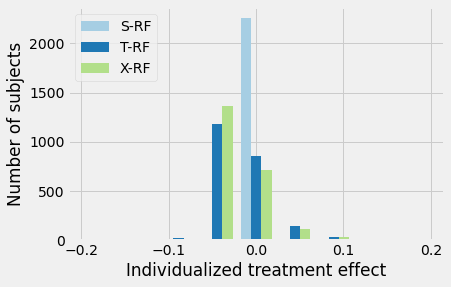

In [49]:
bins = np.linspace(-0.2, 0.2, 10)
plt.hist(data1, bins, label = ['S-RF', 'T-RF', 'X-RF'])
plt.legend(loc='upper left')
plt.xlabel('Individualized treatment effect')
plt.ylabel('Number of subjects')

(array([4.000e+00, 7.000e+00, 2.010e+02, 1.391e+03, 4.850e+02, 1.180e+02,
        3.300e+01, 1.400e+01, 3.000e+00, 1.000e+00]),
 array([-0.14847902, -0.11375547, -0.07903192, -0.04430836, -0.00958481,
         0.02513874,  0.05986229,  0.09458584,  0.12930939,  0.16403295,
         0.1987565 ]),
 <BarContainer object of 10 artists>)

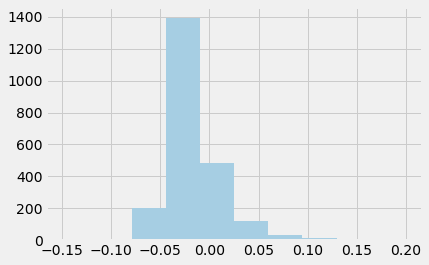

In [64]:
plt.hist(cate_trf.flatten())

## Influence function evaluation method

In [39]:
y_test = df_test0['adrd']

In [40]:
l_test = len(x_test0)
score = rf.predict_proba(x_test0)
e_test = {t: score[0:l_test, t] for t in np.unique(treatment_test)}

In [41]:
xgb_plugin1 = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb_plugin0 = XGBClassifier(max_depth=6, random_state=1108, n_estimators=100)

In [42]:
df_train0.head()

,adrd,treatment,patid,antiasthma,log_count,0,1,2,3,4,...,239,240,241,242,243,244,245,246,247,248
0,0,control,9722,1,1.945910,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,75.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0,Leukotriene receptor antagonist,1232,5,1.386294,0.0,0.0,1.098612,1.098612,0.693147,...,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,control,2220,1,3.583519,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,control,1806,4,0.693147,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,83.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,control,9768,2,1.386294,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
x0 = df_train0.loc[df_train0['treatment'] == 'control', 0:248]

In [44]:
y0 = df_train0.loc[df_train0['treatment'] == 'control', 'adrd']

In [45]:
xgb_plugin0.fit(x0, y0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1108, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [49]:
x1 = df_train0.loc[df_train0['treatment'] != 'control', 0:248]
y1 = df_train0.loc[df_train0['treatment'] != 'control', 'adrd']

In [50]:
sum(y1)

184

In [51]:
xgb_plugin1.fit(x1, y1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1105, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [52]:
y_pred0 = xgb_plugin0.predict(x_test0)
y_pred1 = xgb_plugin1.predict(x_test0)

In [53]:
t_plugin = y_pred1 - y_pred0

In [54]:
ps = rf.predict_proba(x_test0)[:, 1]

In [55]:
a = (treatment_test - ps)

In [56]:
ident = np.array([1]*len(ps))
c = (ps*(ident-ps))

In [57]:
b = np.array([2]*len(treatment_test))*treatment_test*(treatment_test-ps) / c

### X-learner: linear

In [ ]:
cate_x = learner_x.predict(X=x_test0, treatment=treatment_test, p=e_test)
cate = cate_x.flatten()

In [121]:
plug_in = (t_plugin-cate)**2

In [122]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)

In [123]:
(np.sum(l_de) + np.sum(plug_in))

35.78466085161011

### X-learner: random forest based

In [ ]:
cate_xrf = learner_xrf.predict(X=x_test0, treatment=treatment_test, p=e_test)
cate = cate_xrf.flatten()
plug_in = (t_plugin-cate)**2

In [125]:
l_de = (ident - b) * t_plugin + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)

In [126]:
(np.sum(l_de) + np.sum(plug_in))

22.462085594215655

### X-learner: XGboosting based

In [127]:
cate_xgb = learner_xgb.predict(X=x_test0, treatment=treatment_test, p=e_test)
cate = cate_xgb.flatten()
plug_in = (t_plugin-cate)**2

In [128]:
l_de = (ident - b) * t_plugin + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

79.33334439720991

### S-learner: linear based

In [58]:
cate_s = learner_s.predict(X=x_test0, treatment=treatment_test)
cate = cate_s.flatten()
plug_in = (t_plugin-cate)**2

In [59]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) - a*(t_plugin - cate)**2 + cate**2
(np.sum(l_de) + np.sum(plug_in))

22.12460223806866

### S-learner: random forest based

In [60]:
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)
cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2

In [61]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

9.816688026373683

### S-learner: XGboosting based

In [135]:
cate_sxg = learner_sxg.predict(X=x_test0, treatment=treatment_test)
cate = cate_sxg.flatten()
plug_in = (t_plugin-cate)**2

In [136]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

19.014775023760542

### T-learner: linear based

In [76]:
cate_t = learner_t.predict(X=x_test0, treatment=treatment_test)
cate = cate_t.flatten()
plug_in = (t_plugin-cate)**2

In [77]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

155.62833837286718

### T_learner: Random Forest Based

In [1]:
cate_trf = learner_trf.predict(X=x_test0, treatment=treatment_test)
cate = cate_trf.flatten()
plug_in = (t_plugin-cate)**2

NameError: name 'learner_trf' is not defined

In [140]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

21.657762043067557

### T-learner: XGBoosting based

In [141]:
cate_txg = learner_txg.predict(X=x_test0, treatment=treatment_test)
cate = cate_txg.flatten()
plug_in = (t_plugin-cate)**2

In [142]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

57.773423542124064

### R-learner: linear based

In [143]:
cate_r = learner_r.predict(X=x_test0, p=e_test)
cate = cate_r.flatten()
plug_in = (t_plugin-cate)**2

In [144]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

22.613466262292075

### R-learner: XGBoosting

In [145]:
x_test0.head()

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,2.772589,1.791759,0.0,...,0.0,0.0,0.0,86.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,1.098612,0.0,...,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.386294,0.693147,0.0,0.00000,0.0,0.0,2.079442,1.386294,0.0,...,0.0,0.0,0.0,86.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,1.098612,0.0,...,0.0,0.0,0.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.609438,0.000000,0.0,1.94591,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,1.0


In [146]:
cate_rgb = learner_rgb.predict(X=x_test, p=e_test)
cate = cate_rgb.flatten()
plug_in = (t_plugin-cate)**2

In [147]:
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

385.3413966555969

## Causal Forest

In [62]:
cate_cf = pd.read_csv('cforest_pre.csv')

In [64]:
cate = np.array(cate_cf['V1'])

In [65]:
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

18.90607769450703

# SHAP values

In [20]:
x_train0

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.397895,0.693147,0.000000,...,0.0,0.000000,0.0,75.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,1.098612,1.098612,0.693147,0.693147,0.0,2.639057,1.386294,0.000000,...,0.0,0.000000,0.0,72.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.000000,0.000000,0.000000,2.197225,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,74.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.000000,0.000000,0.000000,1.791759,0.0,0.000000,1.098612,0.693147,...,0.0,0.000000,0.0,83.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,90.0,0.0,0.0,0.0,0.0,0.0,1.0
6767,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,83.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,88.0,0.0,0.0,0.0,1.0,0.0,0.0
6769,0.0,0.000000,0.693147,0.000000,0.000000,1.386294,0.0,0.000000,0.000000,0.000000,...,0.0,0.693147,0.0,89.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
w_train0 = x_train0.iloc[:, 0:242]
w_train0

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.397895,0.693147,0.000000,...,0.000000,0.000000,0.693147,0.693147,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.000000,1.098612,1.098612,0.693147,0.693147,0.0,2.639057,1.386294,0.000000,...,0.000000,0.693147,0.000000,0.000000,1.386294,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,2.197225,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,1.791759,0.0,0.000000,1.098612,0.693147,...,0.693147,0.000000,1.386294,2.197225,1.098612,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.098612,1.098612,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
6767,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
6768,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
6769,0.0,0.000000,0.693147,0.000000,0.000000,1.386294,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.693147,0.0


In [22]:
a = le_dx.inverse_transform(list(w_train0.columns))
w_train0.columns = a

In [23]:
w_train0.head(1)

,1002,1005,1009,1010,1013,110,112,172,173,174,...,871,915,916,938,939,949,960,965,979,994
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.397895,0.693147,0.0,...,0.0,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
demo = x_train0.iloc[:, 242:]
demo.columns = ['age at baseline', 'female', 'Asian', 'Black', 'Hispanic', 'Race Unknown', 'White']

In [25]:
x_train_new = pd.concat([w_train0, demo], axis=1)

In [31]:
tau = learner_srf.predict(X=x_train_new, treatment=treatment)
shap_slearner = learner_srf.get_shap_values(X=x_train_new, tau=tau)

In [32]:
feature_names = list(x_train_new.columns)

In [33]:
rpl = {'760': 'Back pain', '395': 'Heart valve disorders', '420': 'Carditis', '716': 'Arthropathies', '727': 'Other disorders of synovium, tendon, and bursa',
      '965': 'Poisoning by analgesics, antipyretics, and antirheumatics', '796': "Elevated prostate specific antigen [PSA]",
      '458': 'Hypertension', '514': 'Abnormal findings examination of lungs', '733': 'Other disorders of bone and cartilage',
      '277': 'Other disorders of metabolism', '38': 'Septicemia', '327': 'Sleep disorders', '690': 'Erythematosquamous dermatosis',
      '274': 'Gout', '720': 'Spinal stenosis', '771': 'Musculoskeletal symptoms referable to limbs', '357': 'Inflammatory and toxic neuropathy',
      '763': 'Thoracic or lumbosacral neuritis or radiculitis, unspecified'}

In [34]:
features_new = [rpl[x] if x in rpl else x for x in feature_names]

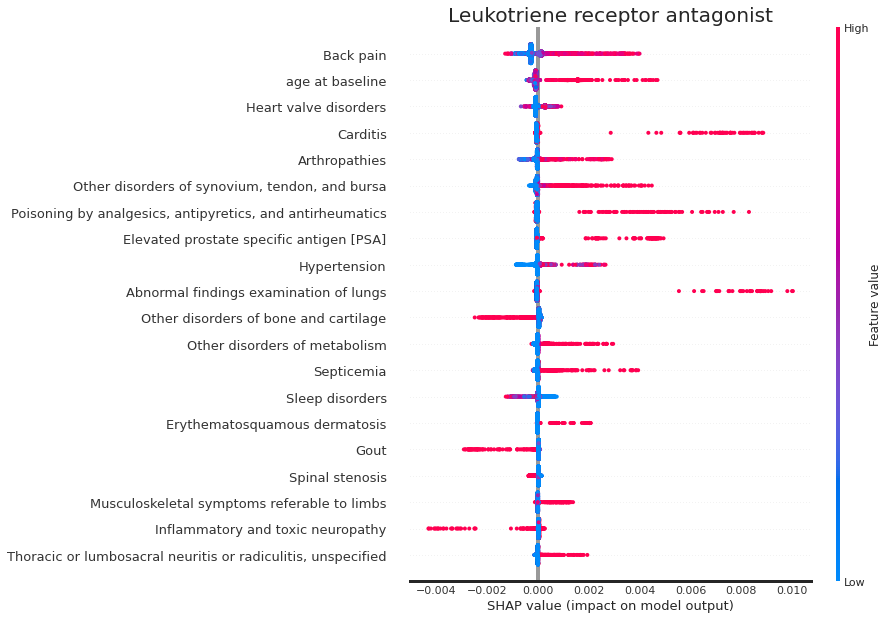

In [39]:
sns.set_style("white")
a = learner_srf.plot_shap_values(X=x_train_new, shap_dict=shap_slearner, features = features_new, matplotlib=True)

In [37]:
import shap

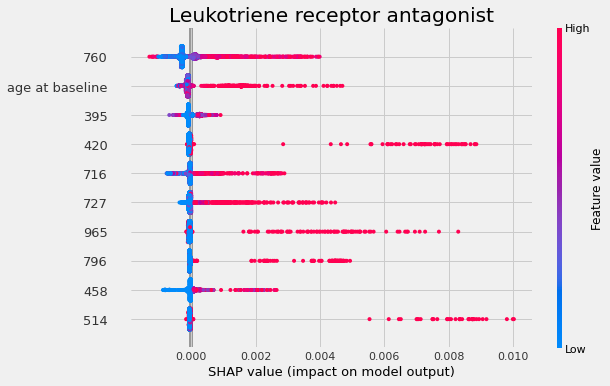

In [48]:
count=0
shap_dict = shap_slearner
for group, values in shap_dict.items():
    plt.title(group)
    shap.summary_plot(values, features=x_train_new, feature_names=feature_names, max_display=10)

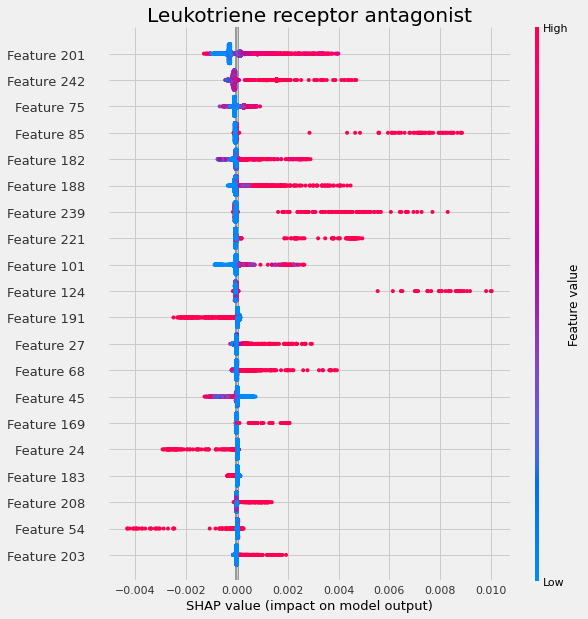

In [34]:
learner_srf.plot_shap_values(X=x_train_new, shap_dict=shap_slearner)

In [71]:
rx2id

{'DB01001': 1,
 'DB13139': 1,
 'DB09082': 1,
 'DB09076': 3,
 'DB01274': 1,
 'DB15784': 1,
 'DB05039': 1,
 'DB00816': 1,
 'DB12846': 1,
 'DB00938': 1,
 'DB00871': 1,
 'DB00277': 4,
 'DB00983': 1,
 'DB13867': 2,
 'DB01222': 2,
 'DB00764': 2,
 'DB00394': 2,
 'DB00180': 2,
 'DB01410': 2,
 'DB00332': 3,
 'DB01303': 4,
 'DB01223': 4,
 'DB00471': 5,
 'DB00744': 5,
 'DB00549': 5,
 'DB01411': 5}

,patid,phecode3,count,log_count,row_idx
52,1,7,10,2.397895,0
53,1,8,1,0.693147,0
54,1,10,1,0.693147,0
55,1,11,3,1.386294,0
56,1,14,2,1.098612,0
...,...,...,...,...,...
590421,11282,220,2,1.098612,6770
590422,11282,225,2,1.098612,6770
590423,11282,234,2,1.098612,6770
590424,11282,235,1,0.693147,6770
